# Image recognition

## Main objective of the analysis

In this analysis we are going to create our own dataset in order to train an image classifier to recognize different geometric forms (ellipses, quadranges and triangles). We are going to train 3 different types of models with one variation:

1. A convolutional neural network from scratch
2. A few layers of **VGG16** Neural Network with a few additional layers (transfer learning)
3. A convolutional neural network from scratch with a variation of epochs and filters

In [1]:
# basic libraries
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# deep learning libraries
import keras
from keras.applications import vgg16
import tensorflow as tf
from keras.applications import *
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

# Create and Explore the Dataset

We are going to create 3 different types of figures:

1. triangles
2. quadrangles
3. ellipses

All of the images are going to be differents because we are going to build them with random attributes, we'll clarify this later. First of all we are going to create a directory called "datasets" with some other directories that will be important for the training, validation and testing processes.

In [2]:
os.mkdir("datasets")

sets=["train","test","validation"]
figures=["triangles","quadrangles","ellipses"]

for set_ in sets:
    os.mkdir(f"datasets/{set_}")
    for figure in figures:
        os.mkdir(f"datasets/{set_}/{figure}")

The next functions create random figures and save them in their respective folders:

In [3]:
# random triangles
def triangles(directory,images):
    for i in range(images):
        x1,x2,x3=random.random(),random.random(),random.random()
        y1,y2,y3=random.random(),x3,x2
        X=[x1,x2,x3,x1]
        Y=[y1,y2,y3,y1]
        plt.plot(X,Y,color="black");
        plt.axis('off');
        plt.savefig(f'datasets/{directory}/triangles/triangle{i}.png')
        if i == 1:
            plt.show()
        plt.clf() 
        
# random quadrangles
def quadrangles(directory,images):
    for i in range(images):
        x1,x2,x3=random.random(),random.random(),random.random()
        y1,y2=random.random(),random.random()
        X=[x1,x1+x2,x1+x3+x2,x1+x3,x1]
        Y=[y1,y2,y2,y1,y1]
        plt.plot(X,Y,color="black");
        plt.axis('off');
        plt.savefig(f'datasets/{directory}/quadrangles/quadrangle{i}.png')
        if i == 1:
            plt.show()
        plt.clf() 

# random ellipses
def ellipses(directory,images):
    for j in range(images):
        a=random.random()                                      #radius on the x-axis
        b=random.random()                                      #radius on the y-axis
        t_rot=2*np.pi*random.random()                          #rotation angle
        t = np.linspace(0, 2*np.pi, 100)                       #steps
        Ell = np.array([a*np.cos(t) , b*np.sin(t)])            #ellipse
        R_rot = np.array([[np.cos(t_rot) , -np.sin(t_rot)],    #2-D rotation matrix
                          [np.sin(t_rot) , np.cos(t_rot)]])  
        Ell_rot = np.zeros((2,Ell.shape[1]))                   #rotated ellipse
        for i in range(Ell.shape[1]):
            Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])

        plt.plot( Ell_rot[0,:] , Ell_rot[1,:],"black" )    
        plt.axis('off');
        plt.savefig(f'datasets/{directory}/ellipses/ellipse{j}.png')
        if j == 1:
            plt.show()
        plt.clf() 

Now we are going to create a dataset with 300 images for the trainning process, 50 for the validation and 1 for the testing. We'll print some forms just for illustrative purposes.

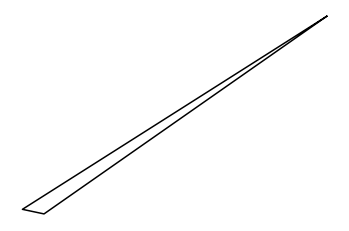

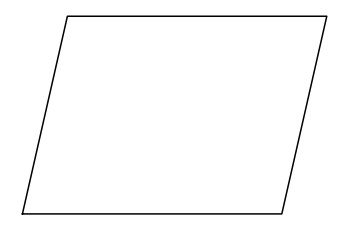

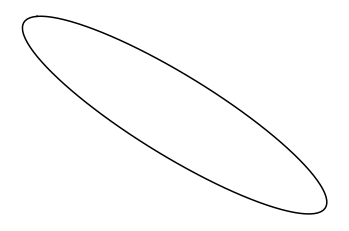

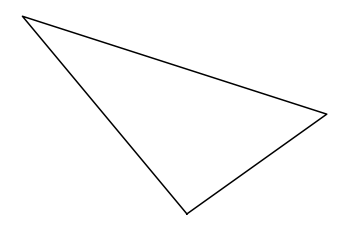

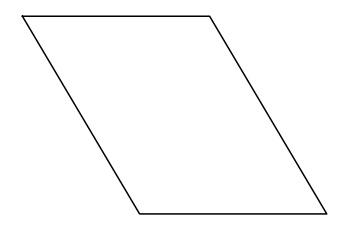

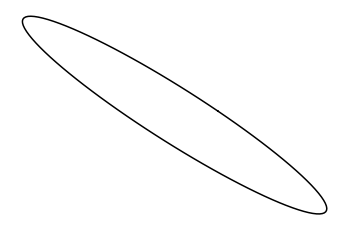

<Figure size 432x288 with 0 Axes>

In [4]:
triangles("train",300)
quadrangles("train",300)
ellipses("train",300)

triangles("validation",50)
quadrangles("validation",50)
ellipses("validation",50)

triangles("test",1)
quadrangles("test",1)
ellipses("test",1)

In [2]:
train_triangle_dir="datasets/train/triangles"
train_quadrangle_dir="datasets/train/quadrangles"
train_ellipse_dir="datasets/train/ellipses"

validation_triangle_dir="datasets/validation/triangles"
validation_quadrangle_dir="datasets/validation/quadrangles"
validation_ellipse_dir="datasets/validation/ellipses"

test_triangle_dir="datasets/test/triangles"
test_quadrangle_dir="datasets/test/quadrangles"
test_ellipse_dir="datasets/test/ellipses"

Now we are going to resize our images in order to make ir easier for our models to process them.

Found 900 images belonging to 3 classes.
Found 150 images belonging to 3 classes.


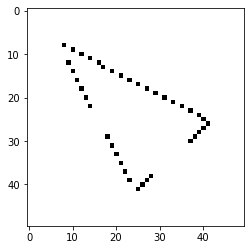

In [3]:
image_gen = ImageDataGenerator(rescale=1/255, horizontal_flip=True) 

train_data_gen = image_gen.flow_from_directory(directory="datasets/train",
                                               batch_size=64,
                                               shuffle=True, 
                                               target_size=(50,50),
                                               class_mode='binary')

image_gen = ImageDataGenerator(rescale=1/255) 

val_data_gen = image_gen.flow_from_directory(directory="datasets/validation",
                                                 batch_size=23,
                                                 target_size=(50,50),
                                                 class_mode='binary')

plt.imshow(train_data_gen[0][0][0])
plt.show()

now lets generate our test batch

Found 3 images belonging to 3 classes.


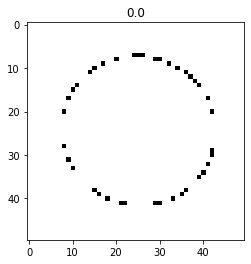

In [4]:
test_batch = image_gen.flow_from_directory(directory="datasets/test",
                                          batch_size=4,
                                          shuffle=True,
                                          target_size=(50,50),
                                          class_mode='binary')
t, l = next(test_batch)
plt.imshow(t[1])
plt.title(l[1])
plt.show()

# Build and Train the Classifier

## Model 1 

- Network with 9 layers:
    - 3 convolutional layers
    - 3 max pooling layers
    - 1 flatten layer
    - 2 dense layers

In [5]:
model1 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(50, 50,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, 'softmax')
])

In [6]:
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

t1 = datetime.now()
# 4 epochs
history_1 = model1.fit(train_data_gen,
                              epochs=4,
                              steps_per_epoch=len(train_data_gen),
                              validation_data=val_data_gen)
train_time_1 = datetime.now() - t1

Epoch 1/4
15/15 [==============================] - 12s 632ms/step - loss: 1.2324 - sparse_categorical_accuracy: 0.3356 - val_loss: 1.1298 - val_sparse_categorical_accuracy: 0.3333
Epoch 2/4
15/15 [==============================] - 8s 574ms/step - loss: 1.0875 - sparse_categorical_accuracy: 0.4033 - val_loss: 1.0372 - val_sparse_categorical_accuracy: 0.5067
Epoch 3/4
15/15 [==============================] - 8s 553ms/step - loss: 0.9510 - sparse_categorical_accuracy: 0.6133 - val_loss: 0.8288 - val_sparse_categorical_accuracy: 0.6200
Epoch 4/4
15/15 [==============================] - 8s 536ms/step - loss: 0.6634 - sparse_categorical_accuracy: 0.7444 - val_loss: 0.5039 - val_sparse_categorical_accuracy: 0.8267


In [7]:
loss_1, test_accuracy_1 = model1.evaluate(test_batch)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss_1))
print('Accuracy on the TEST Set: {:.3%}'.format(test_accuracy_1))

1/1 [==============================] - 0s 134ms/step - loss: 0.6879 - sparse_categorical_accuracy: 0.6667

Loss on the TEST Set: 0.688
Accuracy on the TEST Set: 66.667%


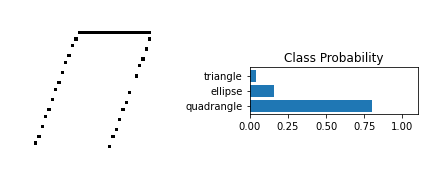

In [32]:
preds = model1.predict(x = np.expand_dims(test_img, axis=0))
# Returns the top K most likely class labels along with the probabilities
probs, class_idx = tf.math.top_k(preds, k=3)
class_names = ['ellipse', 'quadrangle', 'triangle']
classes=[]
for i in class_idx.numpy()[0]:
    classes.append(class_names[i])

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(test_img, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(3), list(probs.numpy()[0]))
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(3))
ax2.set_yticklabels(classes);
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

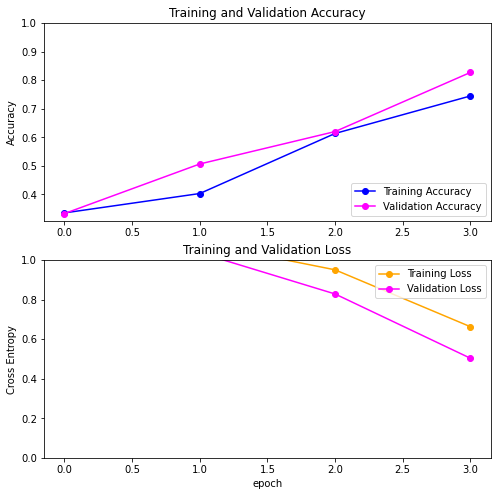

In [9]:
acc = history_1.history['sparse_categorical_accuracy']
val_acc = history_1.history['val_sparse_categorical_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker='o', color="blue")
plt.plot(val_acc, label='Validation Accuracy', marker='o', color="magenta",)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker='o', color="orange")
plt.plot(val_loss, label='Validation Loss', marker='o', color="magenta",)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

The graphs suggest us to increase the number of epochs, we'll do that in model 3.

## Model 2 
- We are going to load the **VGG16** pre-trained network from keras and define a new, untrained network, then add it to VGG16 as a top layer model. Finaly we'll freeze the majority of VGG16 and only train/fine-tune the top layers.

In [10]:
model2 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))
model2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [11]:
top_model2 = Sequential()
top_model2.add(Flatten(input_shape=(model2.output_shape[1:])))
top_model2.add(Dense(1024, activation='relu'))
top_model2.add(Dense(512, activation='relu'))
top_model2.add(Dense(4, activation='softmax'))

model2 = Model(inputs=model2.input, outputs=top_model2(model2.output))

# only train the additional layers and the last layer of VGG16, freeze the rest
for layer in model2.layers[:-(len(top_model2.layers)+1)]:
    layer.trainable = False

In [12]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# 4 epochs
t2 = datetime.now()
history_2 = model2.fit(train_data_gen,
                              epochs=4,
                              steps_per_epoch=len(train_data_gen),
                              validation_data=val_data_gen)
train_time_2 = datetime.now() - t2

Epoch 1/4
15/15 [==============================] - 97s 6s/step - loss: 1.5158 - sparse_categorical_accuracy: 0.5578 - val_loss: 0.8228 - val_sparse_categorical_accuracy: 0.8733
Epoch 2/4
15/15 [==============================] - 96s 6s/step - loss: 0.5597 - sparse_categorical_accuracy: 0.8178 - val_loss: 0.3915 - val_sparse_categorical_accuracy: 0.8333
Epoch 3/4
15/15 [==============================] - 94s 6s/step - loss: 0.2462 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.1923 - val_sparse_categorical_accuracy: 0.9333
Epoch 4/4
15/15 [==============================] - 95s 7s/step - loss: 0.1508 - sparse_categorical_accuracy: 0.9489 - val_loss: 0.1324 - val_sparse_categorical_accuracy: 0.9533


In [13]:
loss_2, test_accuracy_2 = model2.evaluate(test_batch)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss_2))
print('Accuracy on the TEST Set: {:.3%}'.format(test_accuracy_2))

1/1 [==============================] - 0s 329ms/step - loss: 0.0937 - sparse_categorical_accuracy: 1.0000

Loss on the TEST Set: 0.094
Accuracy on the TEST Set: 100.000%


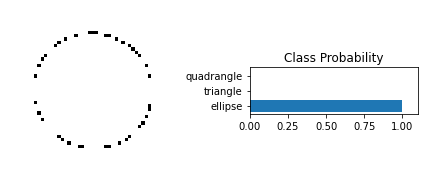

In [34]:
preds = model2.predict(x = np.expand_dims(test_img, axis=0))
probs, class_idx = tf.math.top_k(preds, k=3)
class_names = ['ellipse', 'quadrangle', 'triangle']
classes=[]
for i in class_idx.numpy()[0]:
    classes.append(class_names[i])

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(test_img, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(3), list(probs.numpy()[0]))
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(3))
ax2.set_yticklabels(classes);
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

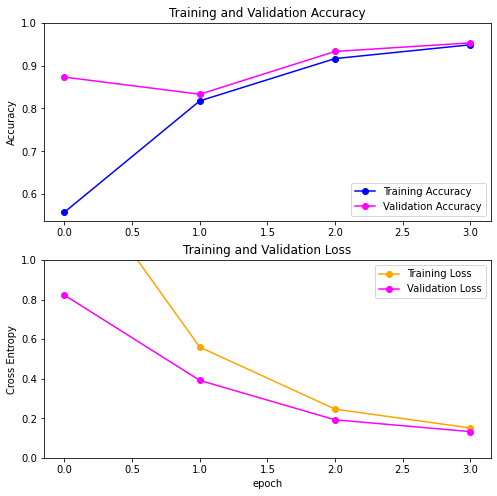

In [15]:
acc = history_2.history['sparse_categorical_accuracy']
val_acc = history_2.history['val_sparse_categorical_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker='o', color="blue")
plt.plot(val_acc, label='Validation Accuracy', marker='o', color="magenta")
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker='o', color="orange")
plt.plot(val_loss, label='Validation Loss', marker='o', color="magenta")
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We can see in the graphs that 4 epochs are good enough.

## Model 3

- Now we are going to take the model 1 and add some epochs and filters, in order to improve accuracy.

In [16]:
model3 = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', input_shape=(50, 50,3)),
    MaxPooling2D(),
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, 'softmax')
])

In [17]:
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

t3 = datetime.now()
# 12 epochs
history_3 = model3.fit(train_data_gen,
                              epochs=10,
                              steps_per_epoch=len(train_data_gen),
                              validation_data=val_data_gen)
train_time_3 = datetime.now() - t3

Epoch 1/10
15/15 [==============================] - 35s 2s/step - loss: 1.1337 - sparse_categorical_accuracy: 0.3756 - val_loss: 0.9127 - val_sparse_categorical_accuracy: 0.7000
Epoch 2/10
15/15 [==============================] - 33s 2s/step - loss: 0.6583 - sparse_categorical_accuracy: 0.7333 - val_loss: 0.4506 - val_sparse_categorical_accuracy: 0.7800
Epoch 3/10
15/15 [==============================] - 32s 2s/step - loss: 0.2957 - sparse_categorical_accuracy: 0.8878 - val_loss: 0.3074 - val_sparse_categorical_accuracy: 0.8933
Epoch 4/10
15/15 [==============================] - 33s 2s/step - loss: 0.2262 - sparse_categorical_accuracy: 0.9322 - val_loss: 0.2846 - val_sparse_categorical_accuracy: 0.9133
Epoch 5/10
15/15 [==============================] - 32s 2s/step - loss: 0.2154 - sparse_categorical_accuracy: 0.9389 - val_loss: 0.1950 - val_sparse_categorical_accuracy: 0.9267
Epoch 6/10
15/15 [==============================] - 33s 2s/step - loss: 0.1217 - sparse_categorical_accuracy: 

In [18]:
loss_3, test_accuracy_3 = model3.evaluate(test_batch)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss_3))
print('Accuracy on the TEST Set: {:.3%}'.format(test_accuracy_3))

1/1 [==============================] - 0s 134ms/step - loss: 0.1903 - sparse_categorical_accuracy: 1.0000

Loss on the TEST Set: 0.190
Accuracy on the TEST Set: 100.000%


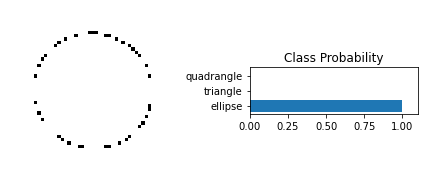

In [35]:
preds = model3.predict(x = np.expand_dims(test_img, axis=0))
# Returns the top K most likely class labels along with the probabilities
probs, class_idx = tf.math.top_k(preds, k=3)
class_names = ['ellipse', 'quadrangle','triangle']
classes=[]
for i in class_idx.numpy()[0]:
    classes.append(class_names[i])

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(test_img, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(3), list(probs.numpy()[0]))
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(3))
ax2.set_yticklabels(classes);
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

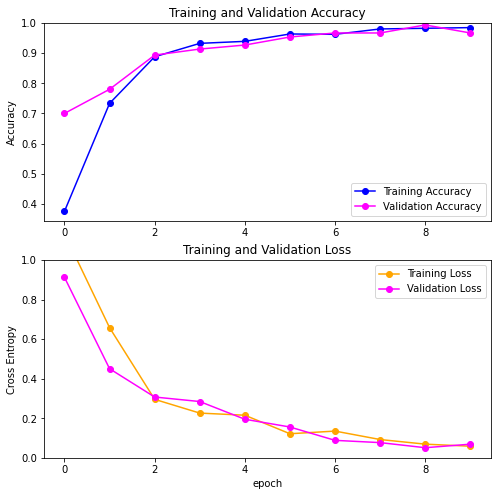

In [20]:
acc = history_3.history['sparse_categorical_accuracy']
val_acc = history_3.history['val_sparse_categorical_accuracy']

loss = history_3.history['loss']
val_loss = history_3.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker='o', color="blue")
plt.plot(val_acc, label='Validation Accuracy', marker='o', color="magenta",)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker='o', color="orange")
plt.plot(val_loss, label='Validation Loss', marker='o', color="magenta",)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We can see in the graphs that 10 epochs are good enough. Maybe we could even accomplish the same with fewer.

## Results report

In [39]:
pd.DataFrame([["CNN from scratch", train_time_1.seconds, 4, #number of epochs in model 1 
               history_1.history['sparse_categorical_accuracy'][-1], test_accuracy_1],
              ["VGG16", train_time_2.seconds, 4, #number of epochs in model 2 
               history_2.history['sparse_categorical_accuracy'][-1], test_accuracy_2],
             ["CNN from scratch 2", train_time_3.seconds, 10, #number of epochs in model 3 
               history_3.history['sparse_categorical_accuracy'][-1], test_accuracy_3]],
             columns=["Model name",'Train time in seconds', 'Number of Epochs', 'Sparse categorical Accuracy in last epoch',
                      'Test accuracy'], index=["Model 1", "Model 2", "Model 3"])

,Model name,Train time in seconds,Number of Epochs,Sparse categorical Accuracy in last epoch,Test accuracy
Model 1,CNN from scratch,40,4,0.744444,0.666667
Model 2,VGG16,475,4,0.948889,1.000000
Model 3,CNN from scratch 2,388,10,0.984444,1.000000


## Key findings and insights

The classsification report of model 2 and 3 above shows that we can predict hieroglyphs with 100% test accuracy, for model 1 the accuracy is 66.66%. The train time for VGG16 with transfer learning is significantly higher than training our CNN from scratch, we have the same accuracy for model 3 in less time.

## Most recommended model

The most reliable models would be, in my opinion, the VGG16 and the CNN from scratch 2, they both run in a similar period of time and give 100% accuracy. 

## Next Steps

We could further experiment trying out with more complex forms, like brand logos, we could detect if there's an adidas or nike logo in a picture, that would be usefull for analysing fashion trends in social networks. 